## PACS Domain Generalization with Vision Transformer (ViT)

## Setup & Imports

In [1]:

import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


c:\Users\Haseeb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration & Seeds

In [2]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS = 5
NUM_CLASSES = 7
DATA_ROOT = "../../../pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
MODELS = {
    "base": "google/vit-base-patch16-224-in21k",
    "small": "WinKawaks/vit-small-patch16-224",
    "tiny": "WinKawaks/vit-tiny-patch16-224"
    }

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Device: cuda


## Dataset Wrapper Class

In [3]:

class PACSDataset:
    def __init__(self, data_root, domains, transform):
        self.data_root = data_root
        self.domains = domains
        self.transform = transform

    def get_dataloader(self, domain, train=True):
        dataset = datasets.ImageFolder(os.path.join(self.data_root, domain), transform=self.transform)
        
        indices = list(range(len(dataset)))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.targets[i] for i in indices], random_state=SEED)
        selected_idx = train_idx if train else val_idx
        
        subset = Subset(dataset, selected_idx)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=train)
        return loader


## Vision Transformer Wrapper Class

In [4]:

class ViTModel(nn.Module):
    def __init__(self, num_classes, model_size = "base"):
        super(ViTModel, self).__init__()
        self.model = ViTForImageClassification.from_pretrained(
            MODELS[model_size],
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, x):
        return self.model(x).logits


## Trainer Class

In [5]:

class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model.to(DEVICE)
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, dataloader):
        self.model.train()
        total_loss = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate(self, dataloader):
        self.model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(inputs)
                preds = torch.argmax(outputs, dim=1)
                total_correct += (preds == labels).sum().item()
                total += labels.size(0)
        return total_correct / total


## Base ViT

### Leave-One-Domain-Out (LODO) Training

In [6]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_base = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_base = ViTModel(NUM_CLASSES, model_size="base")
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_base, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_base = trainer.train(train_loader)
        val_acc_base = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_base:.4f} | Val Acc: {val_acc_base:.4f}")

    # Test
    test_acc_base = trainer.evaluate(test_loader)
    results_base[test_domain] = test_acc_base
    print(f"Test Accuracy on {test_domain}: {test_acc_base:.4f}")

\Testing on domain: art_painting


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\3213515.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [01:21<00:00,  3.23it/s]


Train Loss: 0.5005 | Val Acc: 0.9553
Epoch 2/5


100%|██████████| 265/265 [00:31<00:00,  8.36it/s]


Train Loss: 0.1094 | Val Acc: 0.9585
Epoch 3/5


100%|██████████| 265/265 [00:31<00:00,  8.38it/s]


Train Loss: 0.0657 | Val Acc: 0.9396
Epoch 4/5


100%|██████████| 265/265 [00:31<00:00,  8.35it/s]


Train Loss: 0.0392 | Val Acc: 0.9585
Epoch 5/5


100%|██████████| 265/265 [00:31<00:00,  8.33it/s]


Train Loss: 0.0382 | Val Acc: 0.9553
Test Accuracy on art_painting: 0.9000
\Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:39<00:00,  6.51it/s]


Train Loss: 0.4833 | Val Acc: 0.9451
Epoch 2/5


100%|██████████| 255/255 [00:30<00:00,  8.34it/s]


Train Loss: 0.1115 | Val Acc: 0.9346
Epoch 3/5


100%|██████████| 255/255 [00:30<00:00,  8.29it/s]


Train Loss: 0.0684 | Val Acc: 0.9516
Epoch 4/5


100%|██████████| 255/255 [00:30<00:00,  8.29it/s]


Train Loss: 0.0432 | Val Acc: 0.9471
Epoch 5/5


100%|██████████| 255/255 [00:30<00:00,  8.28it/s]


Train Loss: 0.0509 | Val Acc: 0.9412
Test Accuracy on cartoon: 0.8252
\Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:33<00:00,  8.27it/s]


Train Loss: 0.5252 | Val Acc: 0.9502
Epoch 2/5


100%|██████████| 278/278 [00:33<00:00,  8.34it/s]


Train Loss: 0.1297 | Val Acc: 0.9411
Epoch 3/5


100%|██████████| 278/278 [00:33<00:00,  8.37it/s]


Train Loss: 0.0684 | Val Acc: 0.9604
Epoch 4/5


100%|██████████| 278/278 [00:33<00:00,  8.35it/s]


Train Loss: 0.0444 | Val Acc: 0.9483
Epoch 5/5


100%|██████████| 278/278 [00:33<00:00,  8.37it/s]


Train Loss: 0.0576 | Val Acc: 0.9405
Test Accuracy on photo: 0.9701
\Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:24<00:00,  8.18it/s]


Train Loss: 0.4663 | Val Acc: 0.9711
Epoch 2/5


100%|██████████| 203/203 [00:24<00:00,  8.36it/s]


Train Loss: 0.0731 | Val Acc: 0.9670
Epoch 3/5


100%|██████████| 203/203 [00:24<00:00,  8.36it/s]


Train Loss: 0.0480 | Val Acc: 0.9209
Epoch 4/5


100%|██████████| 203/203 [00:24<00:00,  8.36it/s]


Train Loss: 0.0391 | Val Acc: 0.9629
Epoch 5/5


100%|██████████| 203/203 [00:24<00:00,  8.29it/s]


Train Loss: 0.0268 | Val Acc: 0.9390
Test Accuracy on sketch: 0.5725


### Baseline

In [7]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_base = ViTModel(NUM_CLASSES, model_size="base")
baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_base, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_base = baseline_trainer.train(full_train_loader)
    baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

# Test baseline
baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)
results_base['baseline_all_domains'] = baseline_test_acc_base
print(f"Baseline Test Accuracy: {baseline_test_acc_base:.4f}")


\Baseline: training on all domains and testing on mixed domains


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\3090319873.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:40<00:00,  8.30it/s]


Baseline Loss: 0.4891 | Baseline Acc: 0.8959
Baseline Epoch 2/5


100%|██████████| 333/333 [00:39<00:00,  8.33it/s]


Baseline Loss: 0.1111 | Baseline Acc: 0.9655
Baseline Epoch 3/5


100%|██████████| 333/333 [00:39<00:00,  8.33it/s]


Baseline Loss: 0.0362 | Baseline Acc: 0.9640
Baseline Epoch 4/5


100%|██████████| 333/333 [00:39<00:00,  8.33it/s]


Baseline Loss: 0.0475 | Baseline Acc: 0.9450
Baseline Epoch 5/5


100%|██████████| 333/333 [00:39<00:00,  8.34it/s]


Baseline Loss: 0.0374 | Baseline Acc: 0.9450
Baseline Test Accuracy: 0.9450


### Visual Comparison

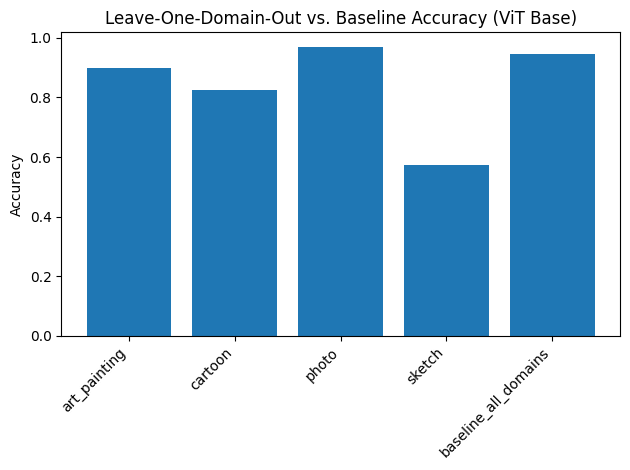

In [8]:
domains = list(results_base.keys())
accuracies = [results_base[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Base)')
plt.tight_layout()
plt.show()

### Final Results

In [9]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_base.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_base.values()) / len(results_base)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.9000
cartoon: 0.8252
photo: 0.9701
sketch: 0.5725
baseline_all_domains: 0.9450

Average Accuracy: 0.8425


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\165815634.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## WinKawaks/ViT Small

### Leave-One-Domain-Out (LODO) Training

In [10]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_small = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_small = ViTModel(NUM_CLASSES, model_size="small")
    optimizer = optim.Adam(model_small.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_small, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_small = trainer.train(train_loader)
        val_acc_small = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_small:.4f} | Val Acc: {val_acc_small:.4f}")

    # Test
    test_acc_small = trainer.evaluate(test_loader)
    results_small[test_domain] = test_acc_small
    print(f"Test Accuracy on {test_domain}: {test_acc_small:.4f}")

\Testing on domain: art_painting


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\2647681507.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [00:17<00:00, 15.47it/s]


Train Loss: 0.3038 | Val Acc: 0.9515
Epoch 2/5


100%|██████████| 265/265 [00:16<00:00, 15.66it/s]


Train Loss: 0.0737 | Val Acc: 0.9408
Epoch 3/5


100%|██████████| 265/265 [00:16<00:00, 15.68it/s]


Train Loss: 0.0693 | Val Acc: 0.9597
Epoch 4/5


100%|██████████| 265/265 [00:16<00:00, 15.68it/s]


Train Loss: 0.0467 | Val Acc: 0.9566
Epoch 5/5


100%|██████████| 265/265 [00:16<00:00, 15.66it/s]


Train Loss: 0.0205 | Val Acc: 0.9484
Test Accuracy on art_painting: 0.8707
\Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:16<00:00, 15.34it/s]


Train Loss: 0.2817 | Val Acc: 0.9529
Epoch 2/5


100%|██████████| 255/255 [00:16<00:00, 15.52it/s]


Train Loss: 0.0904 | Val Acc: 0.9222
Epoch 3/5


100%|██████████| 255/255 [00:16<00:00, 15.47it/s]


Train Loss: 0.0689 | Val Acc: 0.9261
Epoch 4/5


100%|██████████| 255/255 [00:16<00:00, 15.48it/s]


Train Loss: 0.0537 | Val Acc: 0.9529
Epoch 5/5


100%|██████████| 255/255 [00:16<00:00, 15.43it/s]


Train Loss: 0.0427 | Val Acc: 0.9359
Test Accuracy on cartoon: 0.7356
\Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:17<00:00, 15.47it/s]


Train Loss: 0.3481 | Val Acc: 0.9393
Epoch 2/5


100%|██████████| 278/278 [00:17<00:00, 15.57it/s]


Train Loss: 0.0964 | Val Acc: 0.9375
Epoch 3/5


100%|██████████| 278/278 [00:17<00:00, 15.59it/s]


Train Loss: 0.0419 | Val Acc: 0.9544
Epoch 4/5


100%|██████████| 278/278 [00:17<00:00, 15.65it/s]


Train Loss: 0.0371 | Val Acc: 0.9459
Epoch 5/5


100%|██████████| 278/278 [00:17<00:00, 15.66it/s]


Train Loss: 0.0347 | Val Acc: 0.8925
Test Accuracy on photo: 0.9551
\Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:13<00:00, 15.50it/s]


Train Loss: 0.2261 | Val Acc: 0.9456
Epoch 2/5


100%|██████████| 203/203 [00:12<00:00, 15.64it/s]


Train Loss: 0.0475 | Val Acc: 0.9621
Epoch 3/5


100%|██████████| 203/203 [00:12<00:00, 15.65it/s]


Train Loss: 0.0278 | Val Acc: 0.9571
Epoch 4/5


100%|██████████| 203/203 [00:13<00:00, 15.57it/s]


Train Loss: 0.0088 | Val Acc: 0.9604
Epoch 5/5


100%|██████████| 203/203 [00:13<00:00, 15.60it/s]


Train Loss: 0.0804 | Val Acc: 0.9398
Test Accuracy on sketch: 0.5700


### Baseline

In [11]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_small = ViTModel(NUM_CLASSES)
baseline_optimizer = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_small, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_small = baseline_trainer.train(full_train_loader)
    baseline_val_acc_small = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

# Test baseline
baseline_test_acc_small = baseline_trainer.evaluate(full_test_loader)
results_small['baseline_all_domains'] = baseline_test_acc_small
print(f"Baseline Test Accuracy: {baseline_test_acc_small:.4f}")


\Baseline: training on all domains and testing on mixed domains


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\4265002456.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:40<00:00,  8.31it/s]


Baseline Loss: 0.4688 | Baseline Acc: 0.9505
Baseline Epoch 2/5


100%|██████████| 333/333 [00:39<00:00,  8.34it/s]


Baseline Loss: 0.0980 | Baseline Acc: 0.9610
Baseline Epoch 3/5


100%|██████████| 333/333 [00:39<00:00,  8.34it/s]


Baseline Loss: 0.0686 | Baseline Acc: 0.9500
Baseline Epoch 4/5


100%|██████████| 333/333 [00:39<00:00,  8.35it/s]


Baseline Loss: 0.0458 | Baseline Acc: 0.9530
Baseline Epoch 5/5


100%|██████████| 333/333 [00:39<00:00,  8.34it/s]


Baseline Loss: 0.0433 | Baseline Acc: 0.9490
Baseline Test Accuracy: 0.9490


### Visual Comparison

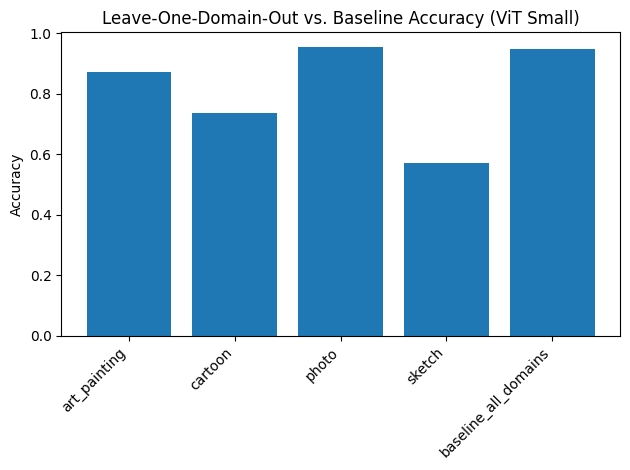

In [12]:
domains = list(results_small.keys())
accuracies = [results_small[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Small)')
plt.tight_layout()
plt.show()

### Final Results

In [13]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_small.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_small.values()) / len(results_small)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.8707
cartoon: 0.7356
photo: 0.9551
sketch: 0.5700
baseline_all_domains: 0.9490

Average Accuracy: 0.8161


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\3963232904.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## WinKawaks/ViT Tiny

### Leave-One-Domain-Out (LODO) Training

In [14]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results_tiny = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model_tiny = ViTModel(NUM_CLASSES, model_size="tiny")
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model_tiny, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss_tiny = trainer.train(train_loader)
        val_acc_tiny = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_tiny:.4f} | Val Acc: {val_acc_tiny:.4f}")

    # Test
    test_acc_tiny = trainer.evaluate(test_loader)
    results_tiny[test_domain] = test_acc_tiny
    print(f"Test Accuracy on {test_domain}: {test_acc_tiny:.4f}")

\Testing on domain: art_painting


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\1596842676.py:10: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Testing on domain: {test_domain}")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [00:12<00:00, 21.75it/s]


Train Loss: 2.3435 | Val Acc: 0.2209
Epoch 2/5


100%|██████████| 265/265 [00:12<00:00, 22.06it/s]


Train Loss: 2.3433 | Val Acc: 0.2209
Epoch 3/5


100%|██████████| 265/265 [00:12<00:00, 22.06it/s]


Train Loss: 2.3434 | Val Acc: 0.2209
Epoch 4/5


100%|██████████| 265/265 [00:11<00:00, 22.09it/s]


Train Loss: 2.3435 | Val Acc: 0.2209
Epoch 5/5


100%|██████████| 265/265 [00:11<00:00, 22.14it/s]


Train Loss: 2.3436 | Val Acc: 0.2209
Test Accuracy on art_painting: 0.2366
\Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:11<00:00, 21.65it/s]


Train Loss: 2.6145 | Val Acc: 0.0922
Epoch 2/5


100%|██████████| 255/255 [00:11<00:00, 21.99it/s]


Train Loss: 2.6146 | Val Acc: 0.0922
Epoch 3/5


100%|██████████| 255/255 [00:11<00:00, 22.01it/s]


Train Loss: 2.6147 | Val Acc: 0.0922
Epoch 4/5


100%|██████████| 255/255 [00:11<00:00, 21.96it/s]


Train Loss: 2.6147 | Val Acc: 0.0922
Epoch 5/5


100%|██████████| 255/255 [00:11<00:00, 22.02it/s]


Train Loss: 2.6145 | Val Acc: 0.0922
Test Accuracy on cartoon: 0.1279
\Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:12<00:00, 21.90it/s]


Train Loss: 2.7195 | Val Acc: 0.0613
Epoch 2/5


100%|██████████| 278/278 [00:12<00:00, 22.18it/s]


Train Loss: 2.7196 | Val Acc: 0.0613
Epoch 3/5


100%|██████████| 278/278 [00:12<00:00, 22.10it/s]


Train Loss: 2.7193 | Val Acc: 0.0613
Epoch 4/5


100%|██████████| 278/278 [00:12<00:00, 22.14it/s]


Train Loss: 2.7203 | Val Acc: 0.0613
Epoch 5/5


100%|██████████| 278/278 [00:12<00:00, 22.03it/s]


Train Loss: 2.7198 | Val Acc: 0.0613
Test Accuracy on photo: 0.1018
\Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([7, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:09<00:00, 21.13it/s]


Train Loss: 2.7015 | Val Acc: 0.1228
Epoch 2/5


100%|██████████| 203/203 [00:09<00:00, 21.85it/s]


Train Loss: 2.6962 | Val Acc: 0.1228
Epoch 3/5


100%|██████████| 203/203 [00:09<00:00, 21.77it/s]


Train Loss: 2.7063 | Val Acc: 0.1228
Epoch 4/5


100%|██████████| 203/203 [00:09<00:00, 21.87it/s]


Train Loss: 2.6987 | Val Acc: 0.1228
Epoch 5/5


100%|██████████| 203/203 [00:09<00:00, 21.64it/s]


Train Loss: 2.6964 | Val Acc: 0.1228
Test Accuracy on sketch: 0.1718


### Baseline

In [15]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model_tiny = ViTModel(NUM_CLASSES)
baseline_optimizer = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model_tiny, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss_tiny = baseline_trainer.train(full_train_loader)
    baseline_val_acc_tiny = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

# Test baseline
baseline_test_acc_tiny = baseline_trainer.evaluate(full_test_loader)
results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
print(f"Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}")


\Baseline: training on all domains and testing on mixed domains


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\3161607150.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\Baseline: training on all domains and testing on mixed domains")
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:40<00:00,  8.25it/s]


Baseline Loss: 0.4382 | Baseline Acc: 0.9435
Baseline Epoch 2/5


100%|██████████| 333/333 [00:40<00:00,  8.29it/s]


Baseline Loss: 0.1051 | Baseline Acc: 0.9470
Baseline Epoch 3/5


100%|██████████| 333/333 [00:40<00:00,  8.27it/s]


Baseline Loss: 0.0680 | Baseline Acc: 0.9570
Baseline Epoch 4/5


100%|██████████| 333/333 [00:39<00:00,  8.33it/s]


Baseline Loss: 0.0301 | Baseline Acc: 0.9545
Baseline Epoch 5/5


100%|██████████| 333/333 [00:39<00:00,  8.34it/s]


Baseline Loss: 0.0413 | Baseline Acc: 0.9625
Baseline Test Accuracy: 0.9625


### Visual Comparison

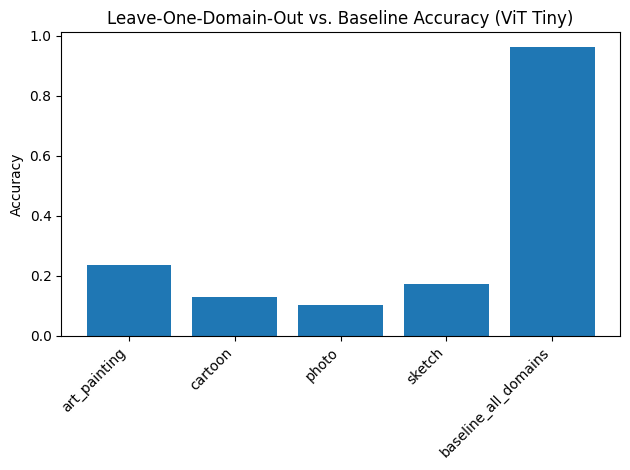

In [16]:
domains = list(results_tiny.keys())
accuracies = [results_tiny[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Tiny)')
plt.tight_layout()
plt.show()

### Final Results

In [17]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_tiny.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_tiny.values()) / len(results_tiny)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.2366
cartoon: 0.1279
photo: 0.1018
sketch: 0.1718
baseline_all_domains: 0.9625

Average Accuracy: 0.3201


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_36960\1740940439.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## Performance Comparison

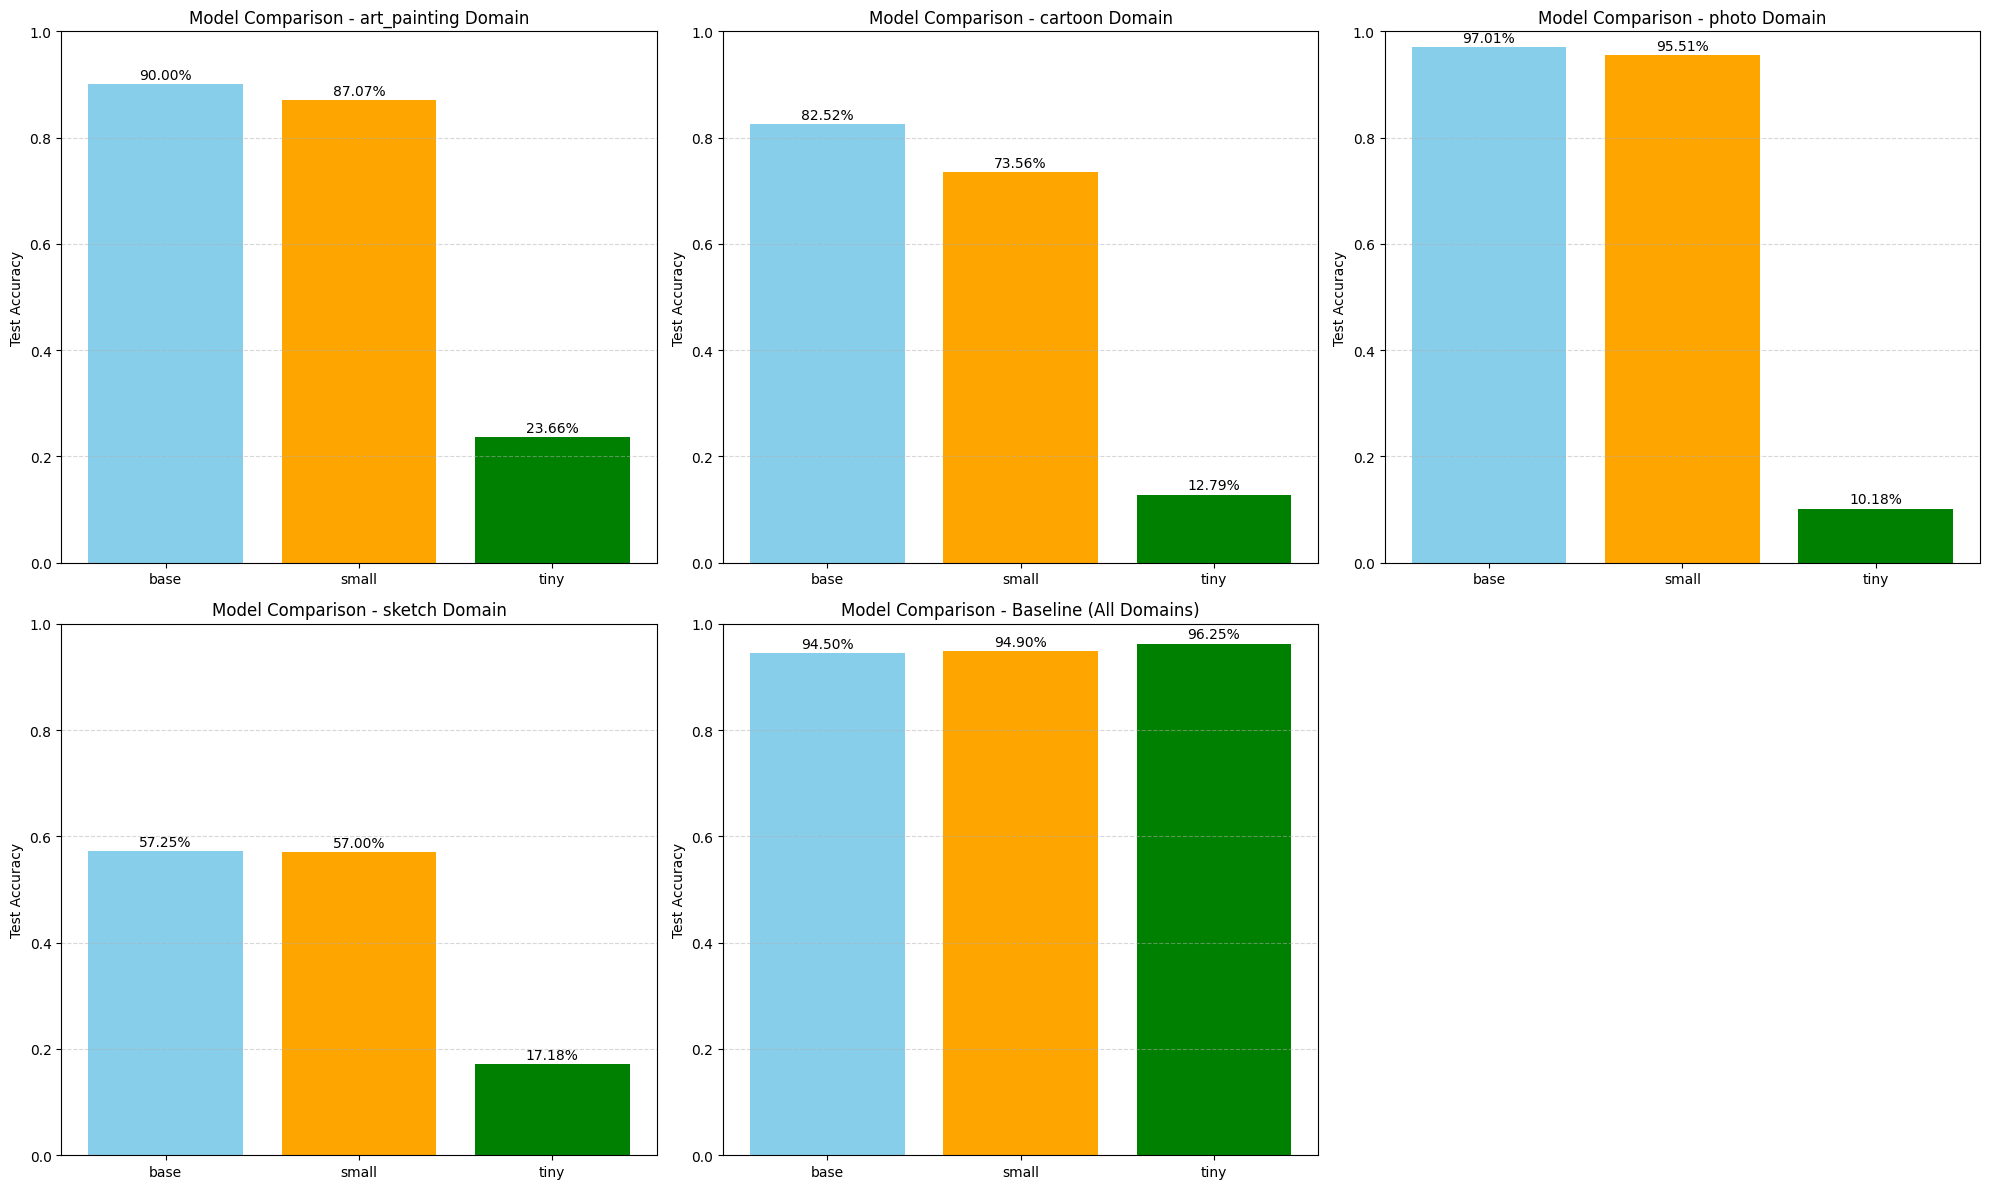


Detailed Performance Comparison:
------------------------------------------------------------
Domain                Base      Small       Tiny
------------------------------------------------------------
art_painting        90.00%     87.07%     23.66%
cartoon             82.52%     73.56%     12.79%
photo               97.01%     95.51%     10.18%
sketch              57.25%     57.00%     17.18%
------------------------------------------------------------
Baseline            94.50%     94.90%     96.25%
------------------------------------------------------------


In [19]:
plt.figure(figsize=(20, 12))

for idx, domain in enumerate(DOMAINS):
    plt.subplot(2, 3, idx + 1)

    domain_accuracies = [
        results_base[domain],
        results_small[domain],
        results_tiny[domain]
    ]

    bars = plt.bar(MODELS.keys(), domain_accuracies, color=["skyblue", "orange", "green"])
    plt.ylim(0, 1)
    plt.ylabel("Test Accuracy")
    plt.title(f"Model Comparison - {domain} Domain")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    
    # Add value labels on top of bars
    for i, acc in enumerate(domain_accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

# Create the baseline comparison subplot
plt.subplot(2, 3, 5) 
baseline_accuracies = [
    results_base["baseline_all_domains"],
    results_small["baseline_all_domains"],
    results_tiny["baseline_all_domains"]
]
plt.bar(MODELS.keys(), baseline_accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Baseline (All Domains)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, acc in enumerate(baseline_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

plt.tight_layout()
plt.show()

print("\nDetailed Performance Comparison:")
print("-" * 60)
print(f"{'Domain':<15} {'Base':>10} {'Small':>10} {'Tiny':>10}")
print("-" * 60)

for domain in DOMAINS:
    print(f"{domain:<15} {results_base[domain]:>10.2%} {results_small[domain]:>10.2%} {results_tiny[domain]:>10.2%}")

print("-" * 60)
print(f"{'Baseline':<15} {results_base['baseline_all_domains']:>10.2%} {results_small['baseline_all_domains']:>10.2%} {results_tiny['baseline_all_domains']:>10.2%}")
print("-" * 60)